<a href="https://colab.research.google.com/github/pachterlab/GCCP_2021/blob/main/test_colab_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install required packages

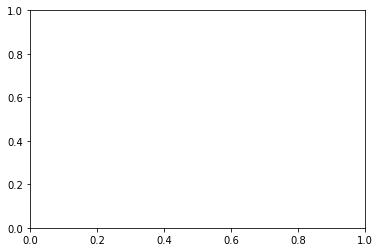

In [1]:
import matplotlib.pyplot as plt
plt.subplot()

In [8]:
%%capture
%pip install scanpy
%pip install scvi-tools==0.8.1
%pip install loompy
%pip install leidenalg

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 1.7.0 which is incompatible.
     |████████████████████████████████| 4.8 MB 4.2 MB/s 
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52040 sha256=f3f9ab561d7e30713e874f16d773412d4a61d75733972eccd565b06c1e8b60e2
  Stored in directory: /root/.cache/pip/wheels/48/36/9f/eb3377d4a7423b96105b6667d36c3faa49ee73b96d8cab80b3
Successfully built loompy
     |████████████████████████████████| 1.3 MB 4.3 MB/s 
     |████████████████████████████████| 3.1 MB 39.0 MB/s 


In [2]:
import torch 
memory_used = torch.cuda.memory_allocated()
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
1
0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# System
import os, pathlib, time, gc

# Math
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Plots
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

# scvi
import anndata
import scvi
import torch

In [5]:
%cd "/content/drive/Shareddrives/scBIVI/scBIVI colab/scBIVI"
!ls

/content/drive/Shareddrives/scBIVI/scBIVI colab/scBIVI
analysis.py	 download_data.sh     preprocess.py	run_scBIVI.py
bivae.py	 experiment_colab.py  __pycache__	run.sh
data		 gena_snippets	      README.txt	scBIVI.ipynb
distribution.py  out		      requirements.txt	scBIVI.py


In [6]:
# scbivi
from scBIVI import scBIVI
from analysis import calculate_accuracy, \
                     plot_corr_comparison, \
                     jaccard_index_split, \
                     knn_overlap


Manual scBIVI code

# Load data 

In [7]:
outdir = 'out/pbmc_10k_v3'
datadir = os.path.join(outdir,'data/preprocessed.h5ad')
logdir = os.path.join(outdir,'out')
percent_keep = 1
cluster_method_split = 'RNA_leiden'

## Load anndata
dataext = pathlib.Path(datadir).suffix
if dataext == '.h5ad':
    adata = anndata.read_h5ad(datadir)
elif dataext == '.loom':
    adata = anndata.read_loom(datadir)

## Downsample the data
if percent_keep < 1:
    X = adata.layers['counts']
    # Convert to numpy array if not already
    try:
        X = X.toarray()
    except:
        pass
    adata.layers['counts'] = np.random.binomial(X.astype('int32'),percent_keep)

# Set up train/test data splits with 5-fold split
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
skf_splits = skf.split(adata, adata.obsm['Cluster'][cluster_method_split])


# Run single instance for testing

Define hyper parameters and model (distribution) type

In [45]:
# Hyper-parameters
lr       = 1e-3
n_latent = 20 # overwritten by setup name
n_epochs = 10
# n_epochs = 20
n_hidden = 1024
n_layers = 2

# model setup
# scBIVI{dist}-{n_latent}-{data type}
# type: 
# setup = 'scBIVIcustom-10-combined'
# setup = 'scBIVI-10-combined'


In [46]:
# Use last of the K-fold splits
for k, (train_index, test_index) in enumerate(skf_splits):
  pass

# setups = [setup]
setups = ['scBIVIcustom-10-combined','scBIVI-10-combined','scBIVIuncorr-10-combined']

cluster_methods = adata.obsm['Cluster'].columns.to_list()
metrics_list = ['recon_error','latent embedding','compute'] + cluster_methods
results_dict = {setup:{metrics: [] for metrics in metrics_list} for setup in setups}

logdir_train = os.path.join(logdir,'train')
os.makedirs(logdir_train, exist_ok=True)

In [47]:
from torch._C import Value
from seaborn.axisgrid import PairGrid
# Define custom_dist if using scBIVIcustom


# Set to default bivariate as example
# from distribution import log_nb_positive_bi
# custom_dist = log_nb_positive_bi
def log_bursty_nb_bi_with_checks(x: torch.Tensor, mu1: torch.Tensor, mu2: torch.Tensor,
                       theta: torch.Tensor, eps=1e-8, **kwargs):
    """
    Log likelihood (scalar) of a minibatch according to a bivariate nb model.
    Parameters
    ----------
    x
        data
    mu1,mu2
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars/2)
    theta
        params (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """

    # Divide the original data x into spliced (x) and unspliced (y)
    n,m = torch.chunk(x,2,dim=-1)

    # THETA_IS_MAT_SHAPE = True #this breaks at 5%
    # THETA_IS_B = False
    # THETA_IS_NAS_SHAPE = False
    
    # THETA_IS_MAT_SHAPE = False #best performance: breaks at 25%
    # THETA_IS_B = True
    # THETA_IS_NAS_SHAPE = False
    
    THETA_IS_MAT_SHAPE = False #best performance: breaks at 65%
    THETA_IS_B = False
    THETA_IS_NAS_SHAPE = True
    if THETA_IS_MAT_SHAPE:
        gamma = 1/theta
        b = mu2*gamma
        beta = b/mu1
    elif THETA_IS_B:
        b = theta
        beta = b/mu1
        gamma = b/mu2
    elif THETA_IS_NAS_SHAPE:
        beta = 1/theta
        b = mu1*beta
        gamma = b/mu2


    if torch.any(~torch.isfinite(gamma)):
        filt = ~torch.isfinite(gamma)
        print(gamma[filt])
        print(b[filt])
        print(beta[filt])
        print(mu1[filt])
        print(mu2[filt])
        print("bad gamma")
        raise ValueError
    if torch.any(~torch.isfinite(beta)):
        print("bad beta")
        raise ValueError
    if torch.any(~torch.isfinite(b)):
        print("bad b")
        raise ValueError

    var1 = mu1 * (1+b)
    var2 = mu2 * (1+b*beta/(beta+gamma))
    cov = b**2/(beta+gamma)
    
    logvar1 = torch.log((var1/mu1**2)+1)
    logvar2 = torch.log((var2/mu2**2)+1)
    logstd1 = torch.sqrt(logvar1)
    logstd2 = torch.sqrt(logvar2)

    logmean1 = torch.log(mu1**2/torch.sqrt(var1+mu1**2))
    logmean2 = torch.log(mu2**2/torch.sqrt(var2+mu2**2))

    if torch.any(~torch.isfinite(logmean1)):
        print("bad logmean1")
        raise ValueError
    if torch.any(~torch.isfinite(logmean2)):
        print("bad logmean2")
        raise ValueError
    if torch.any(~torch.isfinite(logstd1)):
        print("bad logstd1")
        raise ValueError
    if torch.any(~torch.isfinite(logstd2)):
        print("bad logstd2")
        raise ValueError
    if torch.any(~torch.isfinite(cov)):
        print("bad cov")
        raise ValueError

    logcov = torch.log(cov * torch.exp(-(logmean1 + logmean2 + (logvar1 + logvar2)/2)) +1 )
    logcorr = logcov/torch.sqrt(logvar1 * logvar2)
    if torch.any(torch.logical_or((logcorr<0), (logcorr>1))):
        print('excuse me haha what')
        filt = torch.logical_or((logcorr<0), (logcorr>1))
        print('params')
        # print(b[filt])/
        print(gamma[filt][10])
        print(beta[filt][10])
        # print()
        # print('logcov')
        # print(logcov[filt])
        # print('logcorr')
        # print(logcorr[filt])
        raise ValueError('Parameters are wrong!')

    if torch.any(~torch.isfinite(logcov)):
        raise ValueError("bad logcov")
    if torch.any(~torch.isfinite(logcorr)):
        raise ValueError("bad logcorr")

    logmean_cond = logmean2 + logcorr * logstd2/logstd1 * (torch.log(n+1) - logmean1)
    logvar_cond = logvar2 * (1-logcorr**2)  
    # logstd_cond = logstd2 * torch.sqrt(1-logcorr**2)   
    # logvar_cond = logstd_cond**2

    if torch.any(~torch.isfinite(logmean_cond)):
        raise ValueError("bad logmean_cond")
    if torch.any(~torch.isfinite(logcorr**2)):
        raise ValueError('bad square')
    if torch.any(~torch.isfinite((1-logcorr**2)**0.5)):
        print('bad sqrt')
        filt = ~torch.isfinite((1-logcorr**2)**0.5)
        # print('logstd cond')
        # print(logstd_cond[filt])
        print('logstd2')
        print(logstd2[filt])
        print('logcorr')
        print(logcorr[filt])
        print('sqrt')
        print(torch.sqrt(1-logcorr**2)   [filt])
        print('radical argument')
        print((1-logcorr**2)[filt])
        raise ValueError('Something weird in sqrt')
    if torch.any(~torch.isfinite(torch.sqrt(1-logcorr**2))):
        raise ValueError('bad torch.sqrt')
    # if torch.any(~torch.isfinite(logstd_cond)):
    #     print(logstd2)
    #     print(torch.sqrt(1-logcorr**2) )
    #     raise ValueError("bad logstd_cond")
    if torch.any(~torch.isfinite(logvar_cond)):
        raise ValueError("bad logvar_cond")


    mean_cond = torch.exp(logmean_cond + logvar_cond/2)
    var_cond = torch.exp(2*logmean_cond + logvar_cond) * (torch.exp(logvar_cond) - 1)
    if torch.any(~torch.isfinite(mean_cond)):
        raise ValueError("bad mean_cond")
    if torch.any(~torch.isfinite(var_cond)):
        raise ValueError("bad var_cond")

    r = 1/beta
    r_cond = mean_cond**2/(var_cond-mean_cond)
    p_cond = mean_cond/var_cond
    prefactor = torch.lgamma(n+r) - torch.lgamma(n+1) - torch.lgamma(r) \
                + r * torch.log(r/(r+mu1)+eps) + n * torch.log(mu1/(r+mu1)+eps)

    if torch.any(~torch.isfinite(r)):
        raise ValueError("bad r")
    if torch.any(~torch.isfinite(prefactor)):
        raise ValueError("bad prefactor")


    filt = torch.logical_and(torch.logical_and(r>0,p_cond>0), p_cond<1)

    #compute the Poisson mean
    y_ = m * torch.log(mean_cond+eps) - mean_cond - torch.lgamma(m+1) 
    y_[filt] += torch.lgamma(m[filt]+r_cond[filt]) - torch.lgamma(r_cond[filt]) \
                + r_cond[filt] * torch.log(r_cond[filt]/(r_cond[filt]+mean_cond[filt])+eps) \
                - m[filt] * torch.log(r_cond[filt]+mean_cond[filt]+eps) + mean_cond[filt]

    # y_ = torch.lgamma(m+r_cond) - torch.lgamma(m+1) - torch.lgamma(r_cond) \
                # + r_cond * torch.log(r_cond/(r_cond+mean_cond)) \
                # + m * torch.log(mean_cond/(r_cond+mean_cond))
    # y_ = torch.lgamma(m[filt]+r_cond[filt]) - torch.lgamma(m[filt]+1) - torch.lgamma(r_cond[filt]) \
    #             + r_cond[filt] * torch.log(r_cond[filt]/(r_cond[filt]+mean_cond[filt])) \
    #             + m[filt] * torch.log(mean_cond[filt]/(r_cond[filt]+mean_cond[filt]))
    # y_[~filt] = m[~filt] * torch.log(mean_cond[~filt]) - mean_cond[~filt] - torch.lgamma(m[~filt]+1) 
    # print(y_.device)
    # print(y_.shape)
    # print(n.shape)
    # print(filt.shape)
    # print(y_.shape)
    # print(prefactor.shape)
    P = prefactor +  y_
    if torch.any(~torch.isfinite(y_)):
        raise ValueError('bad y_')
    return P

def log_bursty_nb_bi(x: torch.Tensor, mu1: torch.Tensor, mu2: torch.Tensor,
                       theta: torch.Tensor, eps=1e-8, **kwargs):
    """
    Log likelihood (scalar) of a minibatch according to a bivariate nb model.
    Parameters
    ----------
    x
        data
    mu1,mu2
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars/2)
    theta
        params (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """

    # Divide the original data x into spliced (x) and unspliced (y)
    n,m = torch.chunk(x,2,dim=-1)

    # THETA_IS_MAT_SHAPE = True #this breaks at 5%
    # THETA_IS_B = False
    # THETA_IS_NAS_SHAPE = False
    
    # THETA_IS_MAT_SHAPE = False #best performance: breaks at 25%
    # THETA_IS_B = True
    # THETA_IS_NAS_SHAPE = False
    
    THETA_IS_MAT_SHAPE = False #best performance: breaks at 65%
    THETA_IS_B = False
    THETA_IS_NAS_SHAPE = True

    if THETA_IS_MAT_SHAPE:
        gamma = 1/theta
        b = mu2*gamma
        beta = b/mu1
    elif THETA_IS_B:
        b = theta
        beta = b/mu1
        gamma = b/mu2
    elif THETA_IS_NAS_SHAPE:
        beta = 1/theta
        b = mu1*beta
        gamma = b/mu2

    var1 = mu1 * (1+b)
    var2 = mu2 * (1+b*beta/(beta+gamma))
    cov = b**2/(beta+gamma)
    
    logvar1 = torch.log((var1/mu1**2)+1)
    logvar2 = torch.log((var2/mu2**2)+1)
    logstd1 = torch.sqrt(logvar1)
    logstd2 = torch.sqrt(logvar2)

    logmean1 = torch.log(mu1**2/torch.sqrt(var1+mu1**2))
    logmean2 = torch.log(mu2**2/torch.sqrt(var2+mu2**2))

    logcov = torch.log(cov * torch.exp(-(logmean1 + logmean2 + (logvar1 + logvar2)/2)) +1 )
    logcorr = logcov/torch.sqrt(logvar1 * logvar2)


    logmean_cond = logmean2 + logcorr * logstd2/logstd1 * (torch.log(n+1) - logmean1)
    logvar_cond = logvar2 * (1-logcorr**2)  


    mean_cond = torch.exp(logmean_cond + logvar_cond/2)
    var_cond = torch.exp(2*logmean_cond + logvar_cond) * (torch.exp(logvar_cond) - 1)

    r = 1/beta
    r_cond = mean_cond**2/(var_cond-mean_cond)
    p_cond = mean_cond/var_cond
    prefactor = torch.lgamma(n+r) - torch.lgamma(n+1) - torch.lgamma(r) \
                + r * torch.log(r/(r+mu1)+eps) + n * torch.log(mu1/(r+mu1)+eps)

    filt = torch.logical_and(torch.logical_and(r>0,p_cond>0), p_cond<1)

    #compute the Poisson term
    y_ = m * torch.log(mean_cond+eps) - mean_cond - torch.lgamma(m+1) 
    #actually commenting out the next line fixes the Nan gradients... 
    y_[filt] += torch.lgamma(m[filt]+r_cond[filt]) - torch.lgamma(r_cond[filt]) \
                + r_cond[filt] * torch.log(r_cond[filt]/(r_cond[filt]+mean_cond[filt])+eps) \
                - m[filt] * torch.log(r_cond[filt]+mean_cond[filt]+eps) + mean_cond[filt]

    P = prefactor +  y_
    if torch.any(~torch.isfinite(y_)):
        raise ValueError('bad y_')
    return P


custom_dist = log_bursty_nb_bi_with_checks


In [48]:
memory_used = torch.cuda.memory_allocated()
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
1
0


The following seed settings work:
```
scvi._settings.ScviConfig.seed=(8675309)
torch.manual_seed(8675309)
# np.seed(8675309)
np.random.seed(8675309)
```
Any others, who knows...

In [57]:
scvi._settings.ScviConfig.seed=(8675309)
torch.manual_seed(8675309)
# np.seed(8675309)
np.random.seed(8675309)

SETUP=setups[2]

print(SETUP)
method,n_latent,datas = SETUP.split("-")
method_split = method.split('_')
method = method_split[0]

# If set up includes additional argument
additional_kwargs = {s.split('=')[0]: float(s.split('=')[1]) for s in method_split[1:]}

n_latent = int(n_latent)

## Split the data
if datas == 'spliced':
  adata_in = adata[:,:int(adata.shape[1]/2)]
elif datas == 'unspliced':
  adata_in = adata[:,int(adata.shape[1]/2):]
elif datas == 'combined':
  adata_in = adata
else:
  raise ValueError("Input valid datas")

adata_in = adata_in.copy()
scvi.data.setup_anndata(adata_in, layer="counts")

train_adata, test_adata = adata_in[train_index], adata_in[test_index]
train_adata = train_adata.copy()

## Set model parameters
model_args = {'use_cuda'     : True,
              'n_latent'     : n_latent,
              'n_layers'     : n_layers,
              'dispersion'   : 'gene',
              'n_hidden'     : n_hidden,
              'dropout_rate' :  0.1, #shouldn't use this at all
              'gene_likelihood'    :  'nb',
              'log_variational'    :  True,
              'latent_distribution':  'normal'
              }
model_args.update(additional_kwargs)

## Create model
if method == 'LDVAE':
    model = scvi.model.LinearSCVI(train_adata,**model_args)
elif method == 'scVI':
    model = scvi.model.SCVI(train_adata,**model_args)
elif method == "scBIVI":
    model = scBIVI(train_adata,mode='corr',**model_args)
elif method == "scBIVIuncorr":
    model = scBIVI(train_adata,mode='uncorr',**model_args)
elif method == 'scBIVImixed':
    model = scBIVI(train_adata,mode='mixed',**model_args)
elif method == 'scBIVItemp':
    model = scBIVI(train_adata,mode='mixed',**model_args)
elif method == 'scBIVIcustom':
    print(method)
    model = scBIVI(train_adata,mode='custom',
                   custom_dist=custom_dist,**model_args)
else:
    raise Exception('Input valid scVI model')

## Train model
start = time.time()
# print(model)
model.train(n_epochs = n_epochs,
            lr       = lr,
            n_epochs_kl_warmup = n_epochs/2,
            metrics_to_monitor = ['reconstruction_error'],
            frequency = 1,
            train_size = 0.9)

scBIVIuncorr-10-combined
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 11581 cells, 5428 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     Training for 10 epochs                                                              
INFO     KL warmup for 5.0 epochs                                                            
Training...: 100%|██████████| 10/10

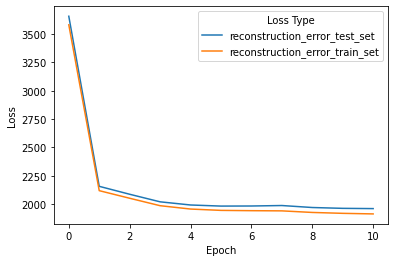

In [58]:
runtime     = time.time() - start
memory_used = torch.cuda.memory_allocated()
results_dict[SETUP]['compute'].append([runtime,memory_used])

## Check train history
df_history = {'reconstruction_error_test_set' : model.history['reconstruction_error_test_set'],
              'reconstruction_error_train_set': model.history['reconstruction_error_train_set']}
df_history = pd.DataFrame(df_history)
df_history = pd.DataFrame(df_history.stack())
df = df_history
df.reset_index(inplace=True)
df.columns = ['Epoch','Loss Type', 'Loss']
figname = f"{SETUP}-{k}"
sns.lineplot(data=df, 
             x='Epoch', 
             y='Loss', 
             hue = 'Loss Type')
# plt.savefig(os.path.join(logdir_train,f"{figname}-train-history.pdf"))
# plt.close()

In [59]:
## Get reconstruction loss on test data
test_error  = model.get_reconstruction_error(test_adata)
train_error = model.get_reconstruction_error(train_adata)
results_dict[SETUP]['recon_error'].append(np.array([train_error,test_error]))

## Extract the embedding space for scVI
X_out = model.get_latent_representation(test_adata)

adata_latent = anndata.AnnData(X_out)
adata_latent.obs = test_adata.obs
results_dict[SETUP]['latent embedding'] = adata_latent
if datas == 'combined':
  test_adata_save = test_adata

INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


INFO     Received view of anndata, making copy.                                              


17824

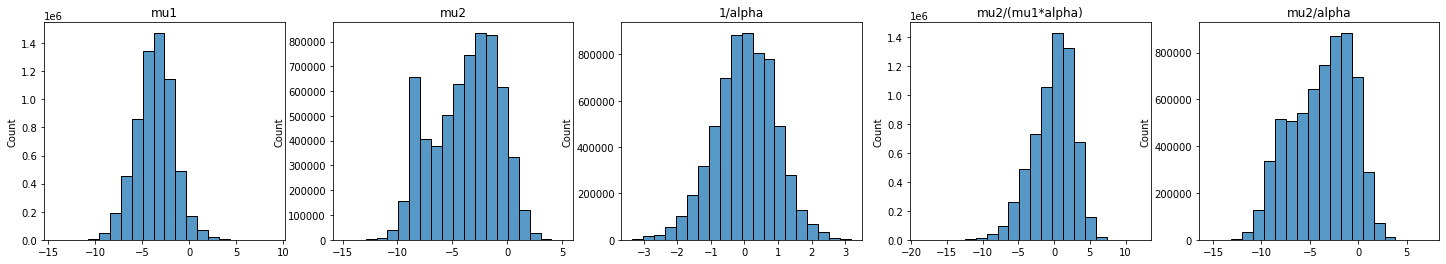

In [60]:
#### Validation with cluster accuracy based on labels
## Iterate through ground truth labels based on different approach

for cluster_method, y in test_adata.obsm['Cluster'].iteritems():

    y = np.array(y.tolist())

    score_dict = calculate_accuracy(X_out,y)
    results_dict[SETUP][cluster_method].append(score_dict)

#### Get predicted distribution
if 'scBIVI' in method:

    params = model.get_likelihood_parameters(test_adata)
    mu = params['mean']
    if method == 'scBIVImixed':
        import torch.nn.functional as F
        mu,mw = np.split(mu,2,axis=1)
        mw_tensor = torch.tensor(mw.reshape(-1,int(mw.shape[1]/2),2))
        mw_softmax = F.softmax(mw_tensor/10e-20,dim=-1)

    mu1,mu2 = np.split(mu,2,axis=1)
    alpha = params['dispersions']

    if mu1.shape[1] == alpha.shape[1]:
        stats = {'mu1': mu1, 'mu2' : mu2,
                  '1/alpha'         : 1/alpha,
                  'mu2/(mu1*alpha)' : mu2/(mu1*alpha),
                  'mu2/alpha'       : mu2/alpha
                  }

        fig,axs = plt.subplots(1,len(stats),
                                figsize=(5*len(stats),4),
                                squeeze=False)

        for ax, (stat,x) in zip(axs.reshape(-1),stats.items()):
            ax = sns.histplot(np.log(x.reshape(-1)),kde=False,ax=ax,bins=20)
            ax.set_title(stat)

        # plt.savefig(os.path.join(logdir_train,f"{figname}-hist.pdf"))
        # plt.close()

#### Correlations

# cg = plot_corr_comparison(X1,X2)
# figname = f"{setup}-{k}"
# plt.title(figname)
# plt.savefig(os.path.join(logdir,f"{figname}-corr.pdf"))
# plt.close()

del model
torch.cuda.empty_cache()
gc.collect()


here u go back and redefine `SETUPS`

In [61]:
# results_dict.keys()

                                Train         Test  KFold
Setup                                                    
scBIVI-10-combined        1935.477192  1938.967412    0.0
scBIVIcustom-10-combined  1929.945857  1937.289428    0.0
scBIVIuncorr-10-combined  1917.560921  1925.631074    0.0


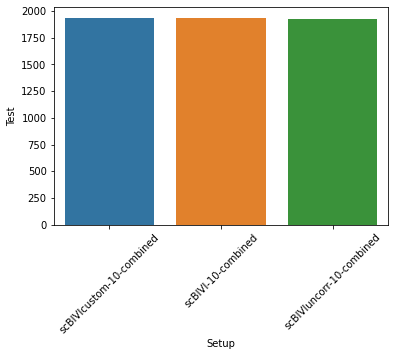

In [62]:
#### Plot NLL
setups = list(results_dict.keys())
df_plot = pd.concat([pd.DataFrame({"Train": -np.array(r['recon_error'])[:,0],
                                   "Test": -np.array(r['recon_error'])[:,1],
                                   'Setup': key}) for key,r in results_dict.items()])

df_plot['KFold'] = df_plot.index
df_plot.reset_index(drop=True)

df_plot.to_csv(os.path.join(logdir,'.svg'))

fig,ax=plt.subplots()
_ = sns.barplot(data=df_plot, x='Setup', y='Test', hue='Setup', dodge=False, ax=ax)
ax.get_legend().remove()
plt.xticks(rotation=45)
# plt.savefig(os.path.join(logdir,'nll.svg'))
# plt.close()

print(df_plot.groupby("Setup").mean())


                      Setup      Metric     Score
0  scBIVIcustom-10-combined         ARI  0.687543
1        scBIVI-10-combined         ARI  0.673958
2  scBIVIuncorr-10-combined         ARI  0.725156
3  scBIVIcustom-10-combined         NMI  0.811726
4        scBIVI-10-combined         NMI  0.804688
5  scBIVIuncorr-10-combined         NMI  0.824531
6  scBIVIcustom-10-combined  silhouette  0.158219
7        scBIVI-10-combined  silhouette  0.165361
8  scBIVIuncorr-10-combined  silhouette  0.173410


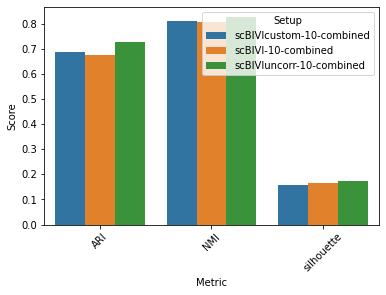

In [63]:
#### Plot clustering accuracy

# iterate through different cluster methods
for cluster_method in cluster_methods:
    df_plot = pd.concat([pd.DataFrame(r[cluster_method]).assign(Setup=key) for key,r in results_dict.items()])
    df_plot.to_csv(os.path.join(logdir,f'clust_acc_{cluster_method}.csv'))
    df_plot = df_plot.melt(id_vars=['Setup'],var_name='Metric',value_name='Score')

    fig,ax=plt.subplots()
    _ = sns.barplot(data=df_plot, x='Metric', y='Score', hue='Setup', ax=ax)
    plt.xticks(rotation=45)
    # plt.savefig(os.path.join(logdir,f'clust_acc_{cluster_method}.svg'))
    # plt.close()
    print(df_plot)

# Loop through all K-folds split and setups

In [21]:
print("{}/{}".format(torch.cuda.memory_allocated(),torch.cuda.max_memory_allocated()))

# Hyper-parameters
lr       = 1e-3
n_latent = 2
n_epochs = 10
n_hidden = 1024
n_layers = 3

#'scBIVIcustom-10-combined'
# setups = ['scBIVI-10-combined',
#           'scVI-10-combined',
#           "scVI-10-spliced",
#           'scVI-10-unspliced',
#           'scBIVIuncorr-10-combined',
#           'scBIVImixed-10-combined']
# setups = ['scBIVItemp_T=0.000001_Trate=0-10-combined']
setups = ['scBIVI-10-combined','scBIVIuncorr-10-combined']

# setups = ['scBIVI-10-combined',
#           'scBIVItemp_T=1_Trate=0.01-10-combined',
#           'scBIVItemp_T=1_Trate=0.0001-10-combined',
#           'scBIVItemp_T=1_Trate=0.000001-10-combined',
#           'scBIVItemp_T=1_Trate=0.00000001-10-combined',
#           'scBIVItemp_T=1_Trate=0-10-combined',
#           'scBIVItemp_T=0.01_Trate=0-10-combined',
#           'scBIVItemp_T=0.0001_Trate=0-10-combined',
#           'scBIVItemp_T=0.000001_Trate=0-10-combined',]

cluster_methods = adata.obsm['Cluster'].columns.to_list()
metrics_list = ['recon_error','latent embedding','compute'] + cluster_methods
results_dict = {setup:{metrics: [] for metrics in metrics_list} for setup in setups}

logdir_train = os.path.join(logdir,'train')
os.makedirs(logdir_train, exist_ok=True)

416758784/560718336


In [27]:
# skf_splits[0]

In [28]:
# for k, (train_index, test_index) in enumerate(skf_splits):
for q in range(1):
    #
  for setup in setups:
      #
    print(setup)
    method,n_latent,datas = setup.split("-")
    method_split = method.split('_')
    method = method_split[0]
    additional_kwargs = {s.split('=')[0]:float(s.split('=')[1]) for s in method_split[1:]}

    n_latent = int(n_latent)

    ## Split the data
    if datas == 'spliced':
      adata_in = adata[:,:int(adata.shape[1]/2)]
    elif datas == 'unspliced':
      adata_in = adata[:,int(adata.shape[1]/2):]
    elif datas == 'combined':
      adata_in = adata
    else:
      raise ValueError("Input valid datas")

    adata_in = adata_in.copy()
    scvi.data.setup_anndata(adata_in, layer="counts")

    train_adata, test_adata = adata_in[train_index], adata_in[test_index]
    train_adata = train_adata.copy()

    ## Set model parameters
    model_args = {'use_cuda'     : True,
                  'n_latent'     : n_latent,
                  'n_layers'     : n_layers,
                  'dispersion'   : 'gene',
                  'n_hidden'     : n_hidden,
                  'dropout_rate' :  0.1,
                  'gene_likelihood'    :  'nb',
                  'log_variational'    :  True,
                  'latent_distribution':  'normal'
                  }
    model_args.update(additional_kwargs)

    ## Create model
    if method == 'LDVAE':
        model = scvi.model.LinearSCVI(train_adata,**model_args)
    elif method == 'scVI':
        model = scvi.model.SCVI(train_adata,**model_args)
    elif method == "scBIVI":
        model = scBIVI(train_adata,mode='corr',**model_args)
    elif method == "scBIVIuncorr":
        model = scBIVI(train_adata,mode='uncorr',**model_args)
    elif method == 'scBIVImixed':
        model = scBIVI(train_adata,mode='mixed',**model_args)
    elif method == 'scBIVItemp':
        # model_args['T'] = 1
        # model_args['Trate'] = 1
        model = scBIVI(train_adata,mode='mixed',**model_args)
    elif method == 'scBIVIcustom':
        model = scBIVI(train_adata,mode='custom',**model_args)
    else:
        raise Exception('Input valid scVI model')

    ## Train model
    start = time.time()
    model.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)

    runtime     = time.time() - start
    memory_used = torch.cuda.memory_allocated()
    results_dict[setup]['compute'].append([runtime,memory_used])

    ## Check train history
    df_history = {'reconstruction_error_test_set' : model.history['reconstruction_error_test_set'],
                  'reconstruction_error_train_set': model.history['reconstruction_error_train_set']}
    df_history = pd.DataFrame(df_history)
    df_history = pd.DataFrame(df_history.stack())
    df = df_history
    df.reset_index(inplace=True)
    df.columns = ['Epoch','Loss Type', 'Loss']
    figname = f"{setup}-{k}"
    sns.lineplot(data=df,x='Epoch', y='Loss', hue = 'Loss Type')
    plt.savefig(os.path.join(logdir_train,f"{figname}-train-history.pdf"))
    plt.close()

    ## Get reconstruction loss on test data
    test_error  = model.get_reconstruction_error(test_adata)
    train_error = model.get_reconstruction_error(train_adata)
    results_dict[setup]['recon_error'].append(np.array([train_error,test_error]))

    ## Extract the embedding space for scVI
    X_out = model.get_latent_representation(test_adata)

    if k == 0:
      adata_latent = anndata.AnnData(X_out)
      adata_latent.obs = test_adata.obs
      results_dict[setup]['latent embedding'] = adata_latent
      if datas == 'combined':
        test_adata_save = test_adata

    #### Validation with cluster accuracy based on labels
    ## Iterate through ground truth labels based on different approach

    for cluster_method, y in test_adata.obsm['Cluster'].iteritems():

        y = np.array(y.tolist())

        score_dict = calculate_accuracy(X_out,y)
        results_dict[setup][cluster_method].append(score_dict)

    #### Get predicted distribution
    if 'scBIVI' in method:

        params = model.get_likelihood_parameters(test_adata)
        mu = params['mean']
        if method == 'scBIVImixed':
            import torch.nn.functional as F
            mu,mw = np.split(mu,2,axis=1)
            mw_tensor = torch.tensor(mw.reshape(-1,int(mw.shape[1]/2),2))
            mw_softmax = F.softmax(mw_tensor/10e-20,dim=-1)

        mu1,mu2 = np.split(mu,2,axis=1)
        alpha = params['dispersions']

        if mu1.shape[1] == alpha.shape[1]:
            stats = {'mu1': mu1, 'mu2' : mu2,
                     '1/alpha'         : 1/alpha,
                     'mu2/(mu1*alpha)' : mu2/(mu1*alpha),
                     'mu2/alpha'       : mu2/alpha
                     }

            fig,axs = plt.subplots(1,len(stats),
                                   figsize=(5*len(stats),4),
                                   squeeze=False)

            for ax, (stat,x) in zip(axs.reshape(-1),stats.items()):
                ax = sns.histplot(np.log(x.reshape(-1)),kde=False,ax=ax,bins=20)
                ax.set_title(stat)

            plt.savefig(os.path.join(logdir_train,f"{figname}-hist.pdf"))
            plt.close()

    #### Correlations

    # cg = plot_corr_comparison(X1,X2)
    # figname = f"{setup}-{k}"
    # plt.title(figname)
    # plt.savefig(os.path.join(logdir,f"{figname}-corr.pdf"))
    # plt.close()

    del model
    torch.cuda.empty_cache()
    gc.collect()


scBIVI-10-combined
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 11581 cells, 5428 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     Training for 10 epochs                                                              
INFO     KL warmup for 5.0 epochs                                                            
Training...: 100%|██████████| 10/10 [00:3

More stuff

scBIVIcustom-3-combined
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 11581 cells, 5428 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
scBIVIcustom
INFO     Training for 10 epochs                                                              
INFO     KL warmup for 5.0 epochs                                                            
Training...: 100%|█████

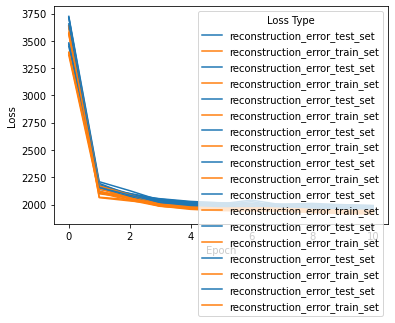

In [88]:
# Use last of the K-fold splits
for k, (train_index, test_index) in enumerate(skf_splits):
  pass

# setups = [setup]
# setups = ['scBIVIcustom-6-combined','scBIVI-6-combined','scBIVIuncorr-6-combined',\
        #   'scBIVIcustom-10-combined','scBIVI-10-combined','scBIVIuncorr-10-combined',]
setups = ['scBIVIcustom-3-combined','scBIVI-3-combined','scBIVIuncorr-3-combined',\
          'scBIVIcustom-6-combined','scBIVI-6-combined','scBIVIuncorr-6-combined',\
          'scBIVIcustom-10-combined','scBIVI-10-combined','scBIVIuncorr-10-combined',]
# setups = ['scBIVIcustom-10-combined','scBIVI-10-combined','scBIVIuncorr-10-combined',]

cluster_methods = adata.obsm['Cluster'].columns.to_list()
metrics_list = ['recon_error','latent embedding','compute'] + cluster_methods
results_dict = {setup:{metrics: [] for metrics in metrics_list} for setup in setups}

logdir_train = os.path.join(logdir,'train')
os.makedirs(logdir_train, exist_ok=True)

for SETUP in setups:

    # SETUP=setups[2]

    print(SETUP)
    method,n_latent,datas = SETUP.split("-")
    method_split = method.split('_')
    method = method_split[0]

    # If set up includes additional argument
    additional_kwargs = {s.split('=')[0]: float(s.split('=')[1]) for s in method_split[1:]}

    n_latent = int(n_latent)

    if n_latent == 3:
        sd = 6
    if n_latent == 6:
        sd = 4
    if n_latent==10:
        sd = 8675309
    scvi._settings.ScviConfig.seed=(sd)
    torch.manual_seed(sd)
    np.random.seed(sd)

    ## Split the data
    if datas == 'spliced':
        adata_in = adata[:,:int(adata.shape[1]/2)]
    elif datas == 'unspliced':
        adata_in = adata[:,int(adata.shape[1]/2):]
    elif datas == 'combined':
        adata_in = adata
    else:
        raise ValueError("Input valid datas")

    adata_in = adata_in.copy()
    scvi.data.setup_anndata(adata_in, layer="counts")

    train_adata, test_adata = adata_in[train_index], adata_in[test_index]
    train_adata = train_adata.copy()

    ## Set model parameters
    model_args = {'use_cuda'     : True,
                'n_latent'     : n_latent,
                'n_layers'     : n_layers,
                'dispersion'   : 'gene',
                'n_hidden'     : n_hidden,
                'dropout_rate' :  0.1, #shouldn't use this at all
                'gene_likelihood'    :  'nb',
                'log_variational'    :  True,
                'latent_distribution':  'normal'
                }
    model_args.update(additional_kwargs)

    ## Create model
    if method == 'LDVAE':
        model = scvi.model.LinearSCVI(train_adata,**model_args)
    elif method == 'scVI':
        model = scvi.model.SCVI(train_adata,**model_args)
    elif method == "scBIVI":
        model = scBIVI(train_adata,mode='corr',**model_args)
    elif method == "scBIVIuncorr":
        model = scBIVI(train_adata,mode='uncorr',**model_args)
    elif method == 'scBIVImixed':
        model = scBIVI(train_adata,mode='mixed',**model_args)
    elif method == 'scBIVItemp':
        model = scBIVI(train_adata,mode='mixed',**model_args)
    elif method == 'scBIVIcustom':
        print(method)
        model = scBIVI(train_adata,mode='custom',
                    custom_dist=custom_dist,**model_args)
    else:
        raise Exception('Input valid scVI model')

    ## Train model
    start = time.time()
    # print(model)
    model.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)
    
    runtime     = time.time() - start
    memory_used = torch.cuda.memory_allocated()
    results_dict[SETUP]['compute'].append([runtime,memory_used])

    ## Check train history
    df_history = {'reconstruction_error_test_set' : model.history['reconstruction_error_test_set'],
                'reconstruction_error_train_set': model.history['reconstruction_error_train_set']}
    df_history = pd.DataFrame(df_history)
    df_history = pd.DataFrame(df_history.stack())
    df = df_history
    df.reset_index(inplace=True)
    df.columns = ['Epoch','Loss Type', 'Loss']
    figname = f"{SETUP}-{k}"
    sns.lineplot(data=df, 
                x='Epoch', 
                y='Loss', 
                hue = 'Loss Type')
    plt.savefig(f"{figname}-train-history.pdf")

    ## Get reconstruction loss on test data
    test_error  = model.get_reconstruction_error(test_adata)
    train_error = model.get_reconstruction_error(train_adata)
    results_dict[SETUP]['recon_error'].append(np.array([train_error,test_error]))

    ## Extract the embedding space for scVI
    X_out = model.get_latent_representation(test_adata)

    adata_latent = anndata.AnnData(X_out)
    adata_latent.obs = test_adata.obs
    results_dict[SETUP]['latent embedding'] = adata_latent
    if datas == 'combined':
        test_adata_save = test_adata
    # plt.close()

        #### Validation with cluster accuracy based on labels
    ## Iterate through ground truth labels based on different approach

    for cluster_method, y in test_adata.obsm['Cluster'].iteritems():

        y = np.array(y.tolist())

        score_dict = calculate_accuracy(X_out,y)
        results_dict[SETUP][cluster_method].append(score_dict)

    del model
    torch.cuda.empty_cache()
    gc.collect()


                                Train         Test  KFold
Setup                                                    
scBIVI-10-combined        1935.477192  1938.967412    0.0
scBIVI-3-combined         1955.669586  1954.095789    0.0
scBIVI-6-combined         1936.989677  1942.221621    0.0
scBIVIcustom-10-combined  1929.945857  1937.289428    0.0
scBIVIcustom-3-combined   1954.626655  1953.540443    0.0
scBIVIcustom-6-combined   1940.372077  1945.256521    0.0
scBIVIuncorr-10-combined  1917.560921  1925.631074    0.0
scBIVIuncorr-3-combined   1953.530405  1951.635734    0.0
scBIVIuncorr-6-combined   1929.234163  1933.909041    0.0


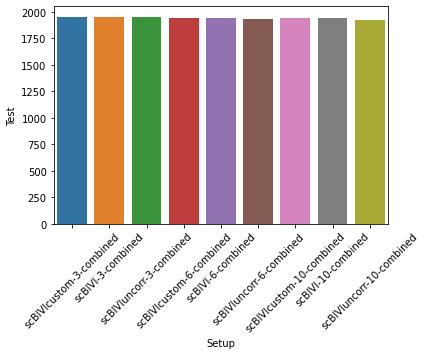

In [89]:
#### Plot NLL
setups = list(results_dict.keys())
df_plot = pd.concat([pd.DataFrame({"Train": -np.array(r['recon_error'])[:,0],
                                   "Test": -np.array(r['recon_error'])[:,1],
                                   'Setup': key}) for key,r in results_dict.items()])

df_plot['KFold'] = df_plot.index
df_plot.reset_index(drop=True)

df_plot.to_csv(os.path.join(logdir,'.svg'))

fig,ax=plt.subplots()
_ = sns.barplot(data=df_plot, x='Setup', y='Test', hue='Setup', dodge=False, ax=ax)
ax.get_legend().remove()
plt.xticks(rotation=45)
# plt.savefig(os.path.join(logdir,'nll.svg'))
# plt.close()

print(df_plot.groupby("Setup").mean())


                       Setup      Metric     Score
0    scBIVIcustom-3-combined         ARI  0.630999
1          scBIVI-3-combined         ARI  0.654402
2    scBIVIuncorr-3-combined         ARI  0.654488
3    scBIVIcustom-6-combined         ARI  0.670762
4          scBIVI-6-combined         ARI  0.694881
5    scBIVIuncorr-6-combined         ARI  0.673695
6   scBIVIcustom-10-combined         ARI  0.687543
7         scBIVI-10-combined         ARI  0.673958
8   scBIVIuncorr-10-combined         ARI  0.725156
9    scBIVIcustom-3-combined         NMI  0.771193
10         scBIVI-3-combined         NMI  0.789533
11   scBIVIuncorr-3-combined         NMI  0.793112
12   scBIVIcustom-6-combined         NMI  0.797786
13         scBIVI-6-combined         NMI  0.805153
14   scBIVIuncorr-6-combined         NMI  0.804064
15  scBIVIcustom-10-combined         NMI  0.811726
16        scBIVI-10-combined         NMI  0.804688
17  scBIVIuncorr-10-combined         NMI  0.824531
18   scBIVIcustom-3-combined  s

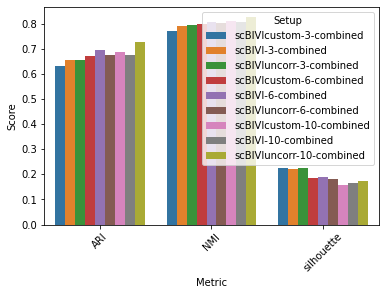

In [90]:
#### Plot clustering accuracy

# iterate through different cluster methods
for cluster_method in cluster_methods:
    df_plot = pd.concat([pd.DataFrame(r[cluster_method]).assign(Setup=key) for key,r in results_dict.items()])
    df_plot.to_csv(os.path.join(logdir,f'clust_acc_{cluster_method}.csv'))
    df_plot = df_plot.melt(id_vars=['Setup'],var_name='Metric',value_name='Score')

    fig,ax=plt.subplots()
    _ = sns.barplot(data=df_plot, x='Metric', y='Score', hue='Setup', ax=ax)
    plt.xticks(rotation=45)
    # plt.savefig(os.path.join(logdir,f'clust_acc_{cluster_method}.svg'))
    # plt.close()
    print(df_plot)